## 1 - Data 

In [1]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from datetime import datetime
import nltk
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import yfinance as yf
import time
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

In [2]:
comments_data = pd.read_csv("/Users/marco/Library/CloudStorage/OneDrive-ErasmusUniversityRotterdam/University - OD/EUR/MSc Thesis/Data/stocktwits_data.csv")
comments_data

,ticker,id,created_at,user,body
0,MMM,574948072,2024-05-31 22:07:52,TheClockworkGroup,"$MMM #NYSE | The markets are unpredictable, bu..."
1,MMM,574928917,2024-05-31 19:37:27,fishinNbanjo,"$MMM wow, that went to hell"
2,MMM,574915317,2024-05-31 18:13:34,RustyToo,$MMM Hear directly from the 3M scientist who w...
3,MMM,574908409,2024-05-31 17:30:20,LiveTradePro,$QQQ Setup confirmed All about follow through...
4,MMM,574908274,2024-05-31 17:29:31,DeepFknValue,@cajunman I was in $MMM preCovid and it just h...
...,...,...,...,...,...
1086042,NVDA,559107987,2024-01-25 00:13:30,Pianonymous,@dracorx What $NVDA bulls are feeling now is w...
1086043,NVDA,559107525,2024-01-25 00:09:20,CharlesXBrown,$LAES $NVDA Is it 12 or 15? Im good either way
1086044,NVDA,559107201,2024-01-25 00:06:21,SonGoku,Nothing is too oversold $TSLA \n\nNothing is t...
1086045,NVDA,559106977,2024-01-25 00:04:15,AthleticBeing,That’s how we trust our conviction and go agai...


In [3]:
comments_data = comments_data.dropna(subset=['created_at', 'ticker', 'body', 'user'])
print(comments_data.isnull().sum())  

ticker        0
id            0
created_at    0
user          0
body          0
dtype: int64


In [4]:
comments_data['created_at'] = pd.to_datetime(comments_data['created_at'])
comments_data

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_4287/2117105917.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments_data['created_at'] = pd.to_datetime(comments_data['created_at'])


,ticker,id,created_at,user,body
0,MMM,574948072,2024-05-31 22:07:52,TheClockworkGroup,"$MMM #NYSE | The markets are unpredictable, bu..."
1,MMM,574928917,2024-05-31 19:37:27,fishinNbanjo,"$MMM wow, that went to hell"
2,MMM,574915317,2024-05-31 18:13:34,RustyToo,$MMM Hear directly from the 3M scientist who w...
3,MMM,574908409,2024-05-31 17:30:20,LiveTradePro,$QQQ Setup confirmed All about follow through...
4,MMM,574908274,2024-05-31 17:29:31,DeepFknValue,@cajunman I was in $MMM preCovid and it just h...
...,...,...,...,...,...
1086042,NVDA,559107987,2024-01-25 00:13:30,Pianonymous,@dracorx What $NVDA bulls are feeling now is w...
1086043,NVDA,559107525,2024-01-25 00:09:20,CharlesXBrown,$LAES $NVDA Is it 12 or 15? Im good either way
1086044,NVDA,559107201,2024-01-25 00:06:21,SonGoku,Nothing is too oversold $TSLA \n\nNothing is t...
1086045,NVDA,559106977,2024-01-25 00:04:15,AthleticBeing,That’s how we trust our conviction and go agai...


### 1.2 Variables Definition

Together with sentiment scores, it's crucial to define other "assistance" variables that may improve the performance of this Stock-Twits factor. Common variabels in social-media studies are attention measures. The design of these attention measures is this study was inspired by the ones defined in [Cookson et al. (2023)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4241505), and then adapted to match Stocktwits attention measures. 

#### Attention Measures

To create an attention measure, we first need to extract the dates and remove the time of creation of the post, in order to pool together posts beloning to the same date.

Then the following variables are created:

* **M_vol** = number of messages per firm per day 
* **Avg_M_firm/d** = average daily message volume per ticker across the whole period
* **M_tot/d** = total messages per day, across al firms 
* **A_Cookson** = attention measure as defined in [Cookson et al. (2023)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4241505). 
* **A_rel** = relative attention measure, computed as the ticker daily message volume over the average daily message volume of that ticker across the whole time frame.

All the variables are then stored in the dataframe: *attention_measures*

In [5]:
comments_data['date'] = pd.to_datetime(comments_data['created_at'].dt.date)

start_date = comments_data['date'].min()
end_date = comments_data['date'].max()
full_date_range = pd.date_range(start=start_date, end=end_date)

all_tickers = comments_data['ticker'].unique()

complete_index = pd.MultiIndex.from_product([all_tickers, full_date_range], names=['ticker', 'date'])
attention_measures = pd.DataFrame(index=complete_index).reset_index()
attention_measures['M_vol'] = 0

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_4287/1979002454.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments_data['date'] = pd.to_datetime(comments_data['created_at'].dt.date)


In [6]:
message_volume = comments_data.groupby(['ticker', 'date']).size().reset_index(name='M_vol')
attention_measures = attention_measures.merge(message_volume, on=['ticker', 'date'], how='left')
attention_measures['M_vol'] = attention_measures['M_vol_y'].fillna(0).astype(int)
attention_measures.drop(columns=['M_vol_x', 'M_vol_y'], inplace=True)

In [7]:
tot_messages = comments_data.groupby('date').size().reset_index(name='M_tot/d')
attention_measures = attention_measures.merge(tot_messages, on='date')

attention_measures['A_Cookson'] = np.where(
    attention_measures['M_vol'] == 0,
    np.nan,  
    attention_measures['M_vol'] / attention_measures['M_tot/d']
)

In [8]:
message_volume = attention_measures[['M_vol', 'ticker']]
average_daily_message_volume = message_volume.groupby('ticker')['M_vol'].mean().reset_index(name='Avg_M_firm/d')
attention_measures = attention_measures.merge(average_daily_message_volume, on='ticker')
attention_measures['A_rel'] = attention_measures['M_vol'] / attention_measures['Avg_M_firm/d']

Given the formulation of the A_Cookson variable ($\frac{Messages_{i,t}}{Messages_t}$), a zero is inserted when there are no messages for firm i on day t in order to avoid missing values.

In [9]:
attention_measures['A_Cookson'] = attention_measures['A_Cookson'].fillna(0)
attention_measures

,ticker,date,M_vol,M_tot/d,A_Cookson,Avg_M_firm/d,A_rel
0,MMM,2024-01-01,4,707,0.005658,16.782895,0.238338
1,MMM,2024-01-02,9,5731,0.001570,16.782895,0.536260
2,MMM,2024-01-03,10,5542,0.001804,16.782895,0.595845
3,MMM,2024-01-04,6,6104,0.000983,16.782895,0.357507
4,MMM,2024-01-05,3,5824,0.000515,16.782895,0.178753
...,...,...,...,...,...,...,...
76299,NVDA,2024-05-27,379,1311,0.289092,1451.098684,0.261181
76300,NVDA,2024-05-28,4915,10814,0.454503,1451.098684,3.387089
76301,NVDA,2024-05-29,4292,11793,0.363945,1451.098684,2.957759
76302,NVDA,2024-05-30,3357,12780,0.262676,1451.098684,2.313420


The attention measures created can be vizualized in a chart like the following:

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_4287/3185434913.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  line1, = ax1.plot(ticker_data.index, ticker_data['A_Cookson'], 'bo', label='Attention', color='royalblue')


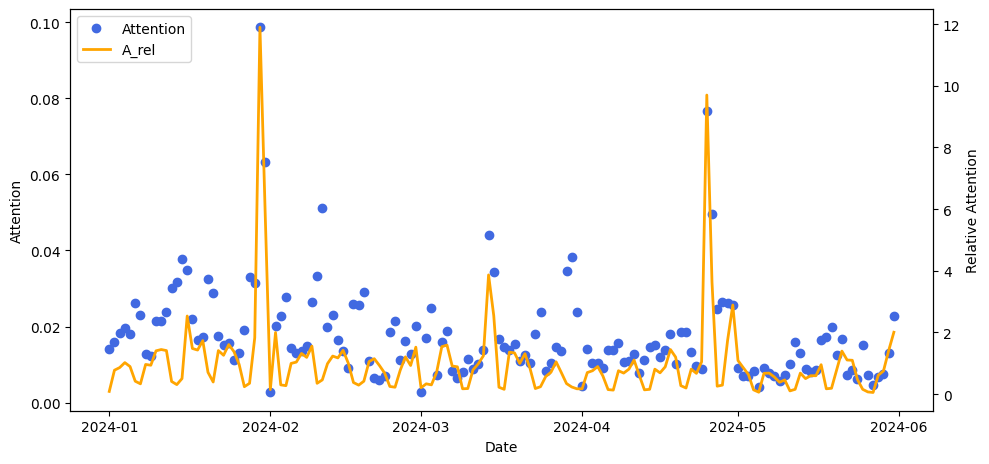

In [10]:
ticker = 'MSFT'

ticker_data = attention_measures[attention_measures['ticker'] == ticker]
ticker_data.set_index('date', inplace=True)
fig, ax1 = plt.subplots(figsize=(10, 5))

line1, = ax1.plot(ticker_data.index, ticker_data['A_Cookson'], 'bo', label='Attention', color='royalblue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Attention')
ax1.tick_params(axis='y', colors='black')

ax2 = ax1.twinx()
line2, = ax2.plot(ticker_data.index, ticker_data['A_rel'], label='Relative Attention', color='orange', linestyle='-', linewidth=2)
ax2.set_ylabel('Relative Attention')
ax2.tick_params(axis='y', colors='black')

fig.legend([line1, line2], ['Attention', 'A_rel'], loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### 1.3 - VADER Sentiment Analysis 

In [11]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/marco/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [12]:
test = comments_data['body'][5]
test

'$MMM 3M is a corrupt and unethical company. Careful.'

In [13]:
sia.polarity_scores(test)

{'neg': 0.303, 'neu': 0.55, 'pos': 0.147, 'compound': -0.4019}

In [14]:
res = {}
for i, row in tqdm(comments_data.iterrows(), total=len(comments_data)):
    text = row['body']
    com_id = row['id']
    res[com_id] = sia.polarity_scores(text)
#takes approx. 2 min to complete

  0%|          | 0/1084175 [00:00<?, ?it/s]

In [15]:
vader = pd.DataFrame(res).T
vader = vader.reset_index().rename(columns={'index': 'id'})
vader = vader.merge(comments_data, how='left')

In [16]:
vader

,id,neg,neu,pos,compound,ticker,created_at,user,body,date
0,574948072,0.000,0.796,0.204,0.8881,MMM,2024-05-31 22:07:52,TheClockworkGroup,"$MMM #NYSE | The markets are unpredictable, bu...",2024-05-31
1,574928917,0.371,0.323,0.306,-0.2023,MMM,2024-05-31 19:37:27,fishinNbanjo,"$MMM wow, that went to hell",2024-05-31
2,574915317,0.038,0.962,0.000,-0.4404,MMM,2024-05-31 18:13:34,RustyToo,$MMM Hear directly from the 3M scientist who w...,2024-05-31
3,574908409,0.000,1.000,0.000,0.0000,MMM,2024-05-31 17:30:20,LiveTradePro,$QQQ Setup confirmed All about follow through...,2024-05-31
4,574908274,0.000,1.000,0.000,0.0000,MMM,2024-05-31 17:29:31,DeepFknValue,@cajunman I was in $MMM preCovid and it just h...,2024-05-31
...,...,...,...,...,...,...,...,...,...,...
1084170,559107987,0.000,0.824,0.176,0.2500,NVDA,2024-01-25 00:13:30,Pianonymous,@dracorx What $NVDA bulls are feeling now is w...,2024-01-25
1084171,559107525,0.000,0.775,0.225,0.4404,NVDA,2024-01-25 00:09:20,CharlesXBrown,$LAES $NVDA Is it 12 or 15? Im good either way,2024-01-25
1084172,559107201,0.000,1.000,0.000,0.0000,NVDA,2024-01-25 00:06:21,SonGoku,Nothing is too oversold $TSLA \n\nNothing is t...,2024-01-25
1084173,559106977,0.107,0.737,0.156,0.5080,NVDA,2024-01-25 00:04:15,AthleticBeing,That’s how we trust our conviction and go agai...,2024-01-25


### 1.4 - RoBERTa Sentiment Analysis

In [17]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [18]:
chunk_size = len(comments_data) // 10  # Split into 10 chunks
chunks = [comments_data[i:i + chunk_size] for i in range(0, len(comments_data), chunk_size)]

In [19]:
MODEL = f'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [20]:
# Run for Roberta Model
encoded_text = tokenizer(test, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
}

print(scores_dict)

{'roberta_neg': 0.9412956, 'roberta_neu': 0.054977484, 'roberta_pos': 0.0037268766}


In [21]:
def polarity_scores_roberta(test):
    encoded_text = tokenizer(test, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

In [22]:
def process_chunk(chunk, chunk_number):
    res = {}
    for i, row in tqdm(chunk.iterrows(), total=len(chunk)):
        try:
            text = row['body']
            com_id = row['id']
            roberta_result = polarity_scores_roberta(text)
            res[com_id] = roberta_result
        except RuntimeError:
            print(f'Broke for id {com_id}')

    result_df = pd.DataFrame.from_dict(res, orient='index')
    result_df.reset_index(inplace=True)
    result_df.rename(columns={'index': 'id'}, inplace=True)

    result_df.to_csv(f'sentiment_results_chunk_{chunk_number}.csv', index=False)
    print(f'Chunk {chunk_number} processed and saved.')

In [23]:
chunk_number = 10  # Specify which chunk to process
process_chunk(chunks[chunk_number], chunk_number)
# Takes 4hrs per chunk -> approximately 40hrs total.

  0%|          | 0/5 [00:00<?, ?it/s]

Chunk 10 processed and saved.


During the roBERTa sentiment analysis, some comments were not successfully processed. Given the low number (240 comments), those were excluded from the dataset.

Now the sentiment analysys results obtained from nltk and roBerta are combined in a sigle data frame to then create variables and start modeling:

In [24]:
l = list(range(0, 11))

data_frames = {}

for i in l:
    data_frames[f'chunk_{i}'] = pd.read_csv(f'/Users/marco/Library/CloudStorage/OneDrive-ErasmusUniversityRotterdam/University - OD/EUR/MSc Thesis/Data/sentiment_results_chunk_{i}.csv')

roberta_sentiment = pd.concat(data_frames.values(), ignore_index=True)

In [25]:
sentiment_data = roberta_sentiment.merge(vader, how='left')
sentiment_data

,id,roberta_neg,roberta_neu,roberta_pos,neg,neu,pos,compound,ticker,created_at,user,body,date
0,574948072,0.003141,0.092694,0.904165,0.000,0.796,0.204,0.8881,MMM,2024-05-31 22:07:52,TheClockworkGroup,"$MMM #NYSE | The markets are unpredictable, bu...",2024-05-31
1,574928917,0.941562,0.051395,0.007044,0.371,0.323,0.306,-0.2023,MMM,2024-05-31 19:37:27,fishinNbanjo,"$MMM wow, that went to hell",2024-05-31
2,574915317,0.704376,0.267132,0.028492,0.038,0.962,0.000,-0.4404,MMM,2024-05-31 18:13:34,RustyToo,$MMM Hear directly from the 3M scientist who w...,2024-05-31
3,574908409,0.003834,0.478237,0.517929,0.000,1.000,0.000,0.0000,MMM,2024-05-31 17:30:20,LiveTradePro,$QQQ Setup confirmed All about follow through...,2024-05-31
4,574908274,0.043001,0.863248,0.093751,0.000,1.000,0.000,0.0000,MMM,2024-05-31 17:29:31,DeepFknValue,@cajunman I was in $MMM preCovid and it just h...,2024-05-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1083930,559107987,0.039442,0.748142,0.212416,0.000,0.824,0.176,0.2500,NVDA,2024-01-25 00:13:30,Pianonymous,@dracorx What $NVDA bulls are feeling now is w...,2024-01-25
1083931,559107525,0.006342,0.156151,0.837507,0.000,0.775,0.225,0.4404,NVDA,2024-01-25 00:09:20,CharlesXBrown,$LAES $NVDA Is it 12 or 15? Im good either way,2024-01-25
1083932,559107201,0.384766,0.536835,0.078398,0.000,1.000,0.000,0.0000,NVDA,2024-01-25 00:06:21,SonGoku,Nothing is too oversold $TSLA \n\nNothing is t...,2024-01-25
1083933,559106977,0.005367,0.115389,0.879243,0.107,0.737,0.156,0.5080,NVDA,2024-01-25 00:04:15,AthleticBeing,That’s how we trust our conviction and go agai...,2024-01-25


#### Sentiment Measures

An overall sentiment meaures is computed as:

$positive\ score_{i,t} + 0 \times neutral\ score_{i,t} - negative\ score_{i,t}$ 

which simplifies to:

\begin{equation}
     positive\ score_{i,t} - negative\ score_{i,t}
\end{equation}

for both vader and roberta values, in order to have a comprehensive sentiment measures that will facilitate the sorting process in the portfolio strategy.

In [26]:
sentiment_data['roberta_S'] = sentiment_data['roberta_pos'] - sentiment_data['roberta_neg']
sentiment_data['vader_S'] = sentiment_data['pos'] - sentiment_data['neg']

In [27]:
sentiment_data

,id,roberta_neg,roberta_neu,roberta_pos,neg,neu,pos,compound,ticker,created_at,user,body,date,roberta_S,vader_S
0,574948072,0.003141,0.092694,0.904165,0.000,0.796,0.204,0.8881,MMM,2024-05-31 22:07:52,TheClockworkGroup,"$MMM #NYSE | The markets are unpredictable, bu...",2024-05-31,0.901024,0.204
1,574928917,0.941562,0.051395,0.007044,0.371,0.323,0.306,-0.2023,MMM,2024-05-31 19:37:27,fishinNbanjo,"$MMM wow, that went to hell",2024-05-31,-0.934518,-0.065
2,574915317,0.704376,0.267132,0.028492,0.038,0.962,0.000,-0.4404,MMM,2024-05-31 18:13:34,RustyToo,$MMM Hear directly from the 3M scientist who w...,2024-05-31,-0.675884,-0.038
3,574908409,0.003834,0.478237,0.517929,0.000,1.000,0.000,0.0000,MMM,2024-05-31 17:30:20,LiveTradePro,$QQQ Setup confirmed All about follow through...,2024-05-31,0.514095,0.000
4,574908274,0.043001,0.863248,0.093751,0.000,1.000,0.000,0.0000,MMM,2024-05-31 17:29:31,DeepFknValue,@cajunman I was in $MMM preCovid and it just h...,2024-05-31,0.050750,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1083930,559107987,0.039442,0.748142,0.212416,0.000,0.824,0.176,0.2500,NVDA,2024-01-25 00:13:30,Pianonymous,@dracorx What $NVDA bulls are feeling now is w...,2024-01-25,0.172975,0.176
1083931,559107525,0.006342,0.156151,0.837507,0.000,0.775,0.225,0.4404,NVDA,2024-01-25 00:09:20,CharlesXBrown,$LAES $NVDA Is it 12 or 15? Im good either way,2024-01-25,0.831164,0.225
1083932,559107201,0.384766,0.536835,0.078398,0.000,1.000,0.000,0.0000,NVDA,2024-01-25 00:06:21,SonGoku,Nothing is too oversold $TSLA \n\nNothing is t...,2024-01-25,-0.306368,0.000
1083933,559106977,0.005367,0.115389,0.879243,0.107,0.737,0.156,0.5080,NVDA,2024-01-25 00:04:15,AthleticBeing,That’s how we trust our conviction and go agai...,2024-01-25,0.873876,0.049


In [28]:
to_drop = ['id', 'user', 'body', 'created_at', 'ticker', 'date']
columns = [i for i in list(sentiment_data.columns) if i not in to_drop]

daily_sentiment = sentiment_data.groupby(['ticker', 'date'])[columns].mean().reset_index()
daily_sentiment

,ticker,date,roberta_neg,roberta_neu,roberta_pos,neg,neu,pos,compound,roberta_S,vader_S
0,A,2024-01-01,0.019773,0.562884,0.417344,0.0000,0.7810,0.2190,0.63690,0.397571,0.2190
1,A,2024-01-04,0.269511,0.553767,0.176721,0.0000,1.0000,0.0000,0.00000,-0.092790,0.0000
2,A,2024-01-05,0.281703,0.678933,0.039364,0.0540,0.8804,0.0656,0.09600,-0.242340,0.0116
3,A,2024-01-06,0.025090,0.906964,0.067947,0.0000,1.0000,0.0000,0.00000,0.042857,0.0000
4,A,2024-01-07,0.015686,0.800739,0.183575,0.0000,0.7920,0.2080,0.63690,0.167889,0.2080
...,...,...,...,...,...,...,...,...,...,...,...
42274,ZTS,2024-05-24,0.050144,0.323142,0.626715,0.0305,0.8040,0.1655,0.45435,0.576571,0.1350
42275,ZTS,2024-05-25,0.284887,0.641280,0.073833,0.0000,0.9240,0.0760,0.31820,-0.211054,0.0760
42276,ZTS,2024-05-28,0.138578,0.751024,0.110398,0.0000,1.0000,0.0000,0.00000,-0.028180,0.0000
42277,ZTS,2024-05-29,0.080666,0.726350,0.192984,0.0000,0.9275,0.0725,0.14800,0.112318,0.0725


#### Social Media Dataset - Variables

In [29]:
social_media_data = pd.merge(attention_measures, daily_sentiment, on=['ticker', 'date'], how='left')

**Note:** 

There are a few important considerations regarding the dataframes and time spans used. From January 1st to May 31st, there are 153 days, which, when multiplied by the 502 tickers, totals 76,304 observations in the attention measures dataset. However, not all companies receive comments every day—some have zero comments on certain days—resulting in a smaller daily sentiment dataset with 42,279 observations. This discrepancy is due to the aforementioned reason. Additionally, the next section references 51,876 observations because only 106 of the 153 days are trading days with available stock market and returns data.

### 1.5 - Importing Financial Data

Note that *GE Vervnova Inc* (GEV) and *Solventum Corp* (SOLV) have specific situations:

* GEV spineed-off from GE in April, meaning that it's a new stock with no price data until April.
* SOLV IPOd in April

There is no data covering the full time period for these two companies, but given that the twits match their price data, they will still be included in the analysis, while taking into account that there is only one month of data available.

In [30]:
tickers = list(comments_data['ticker'].unique())
tickers.remove('BRK.B')
tickers.remove('BF.B')

start_date = '2023-12-28'
end_date = '2024-06-01'

def get_data(ticker_subset):
    prices = yf.download(ticker_subset, start=start_date, end=end_date)
    adj_close = prices['Adj Close']
    returns = adj_close.pct_change()
    returns_long = returns.reset_index().melt(id_vars='Date', var_name='ticker', value_name='ret')
    return returns_long

rets = get_data(tickers)
rets = rets.dropna()
rets.rename(columns={'Date': 'date'}, inplace=True)

[*********************100%%**********************]  500 of 500 completed


In [31]:
MSFT = yf.download('MSFT', start=start_date, end=end_date)
(MSFT['High'] - MSFT['Low']).mean()

[*********************100%%**********************]  1 of 1 completed


6.440374926985982

In [32]:
A = yf.download('A', start=start_date, end=end_date)
(A['High'] - A['Low']).mean()

[*********************100%%**********************]  1 of 1 completed


3.0422433157947575

### 1.6 Fama-French Data

Fama-French factor data is necessary in this reasearch mainly to evaluate 3- and 5-factor alpha when operating with portfolio sorts. In that way it is possible to evaluate the risk-adjusted returns of the StockTwits factor. However, they are also necessary to compute excess retursn, as the FF-dataframe also includes data for the risk-free rate *$r_f$*. 

*The data was downloaded from the [Fama-French data library](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html)*.

In [33]:
FF_data = pd.read_csv("/Users/marco/Library/CloudStorage/OneDrive-ErasmusUniversityRotterdam/University - OD/EUR/MSc Thesis/Data/F&F_data.csv", header=2)
FF_data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
FF_data['date'] = pd.to_datetime(FF_data['date'], format='%Y%m%d')
FF_data = FF_data[(FF_data['date'] >= '2023-12-29') & (FF_data['date'] <= '2024-05-31')]

to_divide = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
for i in to_divide:
    FF_data[i] = FF_data[i]/100
FF_data

,date,Mkt-RF,SMB,HML,RMW,CMA,RF
15228,2023-12-29,-0.0043,-0.0113,-0.0037,0.0068,-0.0007,0.00021
15229,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.00022
15230,2024-01-03,-0.0101,-0.0194,-0.0011,0.0033,-0.0018,0.00022
15231,2024-01-04,-0.0033,0.0024,0.0009,-0.0041,0.0024,0.00022
15232,2024-01-05,0.0015,-0.0059,0.0064,0.0011,-0.0015,0.00022
...,...,...,...,...,...,...,...
15329,2024-05-24,0.0072,0.0017,0.0016,0.0031,-0.0039,0.00020
15330,2024-05-28,-0.0004,0.0010,-0.0089,0.0005,-0.0112,0.00020
15331,2024-05-29,-0.0077,-0.0039,-0.0062,0.0048,-0.0002,0.00020
15332,2024-05-30,-0.0053,0.0136,0.0099,0.0034,0.0107,0.00020


In [34]:
research_data = pd.merge(FF_data, social_media_data, on='date', how='left')
research_data = pd.merge(research_data, rets, on=['date', 'ticker'], how='left')
research_data

,date,Mkt-RF,SMB,HML,RMW,CMA,RF,ticker,M_vol,M_tot/d,...,roberta_neg,roberta_neu,roberta_pos,neg,neu,pos,compound,roberta_S,vader_S,ret
0,2023-12-29,-0.0043,-0.0113,-0.0037,0.0068,-0.0007,0.00021,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.00022,MMM,9.0,5731.0,...,0.081047,0.669640,0.249313,0.053222,0.800111,0.146667,0.155311,0.168266,0.093444,0.006220
2,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.00022,AOS,2.0,5731.0,...,0.374486,0.572005,0.053510,0.191500,0.808500,0.000000,-0.238350,-0.320976,-0.191500,-0.012130
3,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.00022,ABT,4.0,5731.0,...,0.156287,0.647608,0.196105,0.000000,0.948000,0.052000,0.159225,0.039818,0.052000,-0.001999
4,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.00022,ABBV,22.0,5731.0,...,0.056310,0.704331,0.239359,0.006227,0.906909,0.086818,0.153368,0.183050,0.080591,0.031296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52706,2024-05-31,0.0068,-0.0003,0.0078,0.0091,0.0080,0.00020,MSFT,236.0,10406.0,...,0.266645,0.501310,0.232045,0.092458,0.813492,0.094055,0.028573,-0.034601,0.001597,0.001109
52707,2024-05-31,0.0068,-0.0003,0.0078,0.0091,0.0080,0.00020,TSLA,1072.0,10406.0,...,0.274290,0.501777,0.223934,0.073376,0.841557,0.085062,0.026171,-0.050356,0.011686,-0.003971
52708,2024-05-31,0.0068,-0.0003,0.0078,0.0091,0.0080,0.00020,AMZN,483.0,10406.0,...,0.313564,0.478393,0.208043,0.097880,0.798602,0.103520,0.015593,-0.105522,0.005640,-0.016061
52709,2024-05-31,0.0068,-0.0003,0.0078,0.0091,0.0080,0.00020,GOOG,15.0,10406.0,...,0.242113,0.458476,0.299411,0.066533,0.852200,0.081267,0.104940,0.057298,0.014733,0.002305


### 1.7 Final Data Preprocessing

For this reasearch, only trading days will be taken into account due to the fact that return data is not available for non-trading days. This will lead to the exclusion of sentiment and attention measures derived from non-trading days, and to the simplifying assumptions that sentiment for fridays affects the returns on mondays for instance. 

In [35]:
research_data = research_data.dropna(subset='ret')
research_data

,date,Mkt-RF,SMB,HML,RMW,CMA,RF,ticker,M_vol,M_tot/d,...,roberta_neg,roberta_neu,roberta_pos,neg,neu,pos,compound,roberta_S,vader_S,ret
1,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.00022,MMM,9.0,5731.0,...,0.081047,0.669640,0.249313,0.053222,0.800111,0.146667,0.155311,0.168266,0.093444,0.006220
2,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.00022,AOS,2.0,5731.0,...,0.374486,0.572005,0.053510,0.191500,0.808500,0.000000,-0.238350,-0.320976,-0.191500,-0.012130
3,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.00022,ABT,4.0,5731.0,...,0.156287,0.647608,0.196105,0.000000,0.948000,0.052000,0.159225,0.039818,0.052000,-0.001999
4,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.00022,ABBV,22.0,5731.0,...,0.056310,0.704331,0.239359,0.006227,0.906909,0.086818,0.153368,0.183050,0.080591,0.031296
5,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.00022,ACN,1.0,5731.0,...,0.004133,0.152763,0.843104,0.000000,1.000000,0.000000,0.000000,0.838971,0.000000,-0.011370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52706,2024-05-31,0.0068,-0.0003,0.0078,0.0091,0.0080,0.00020,MSFT,236.0,10406.0,...,0.266645,0.501310,0.232045,0.092458,0.813492,0.094055,0.028573,-0.034601,0.001597,0.001109
52707,2024-05-31,0.0068,-0.0003,0.0078,0.0091,0.0080,0.00020,TSLA,1072.0,10406.0,...,0.274290,0.501777,0.223934,0.073376,0.841557,0.085062,0.026171,-0.050356,0.011686,-0.003971
52708,2024-05-31,0.0068,-0.0003,0.0078,0.0091,0.0080,0.00020,AMZN,483.0,10406.0,...,0.313564,0.478393,0.208043,0.097880,0.798602,0.103520,0.015593,-0.105522,0.005640,-0.016061
52709,2024-05-31,0.0068,-0.0003,0.0078,0.0091,0.0080,0.00020,GOOG,15.0,10406.0,...,0.242113,0.458476,0.299411,0.066533,0.852200,0.081267,0.104940,0.057298,0.014733,0.002305


We are going to work with excess returns, which will be computed by subtracting the risk-free rate RF from the ret column:

In [38]:
research_data['exc_ret'] = research_data['ret']-research_data['RF']
research_data

,date,Mkt-RF,SMB,HML,RMW,CMA,RF,ticker,M_vol,M_tot/d,...,neg,neu,pos,compound,roberta_S,vader_S,ret,Ab_ret,Ab_ret_nd,exc_ret
9,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.00022,A,0.0,5731.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.002014,0.004986,-0.044603,-0.002234
511,2024-01-03,-0.0101,-0.0194,-0.0011,0.0033,-0.0018,0.00022,A,0.0,5542.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.054703,-0.044603,0.002080,-0.054923
1013,2024-01-04,-0.0033,0.0024,0.0009,-0.0041,0.0024,0.00022,A,1.0,6104.0,...,0.0000,1.0000,0.0000,0.00000,-0.092790,0.0000,-0.001220,0.002080,-0.004859,-0.001440
1515,2024-01-05,0.0015,-0.0059,0.0064,0.0011,-0.0015,0.00022,A,5.0,5824.0,...,0.0540,0.8804,0.0656,0.09600,-0.242340,0.0116,-0.003359,-0.004859,0.006699,-0.003579
2017,2024-01-08,0.0149,0.0053,-0.0127,-0.0098,-0.0047,0.00022,A,0.0,8911.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.021599,0.006699,-0.018143,0.021379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50184,2024-05-23,-0.0085,-0.0066,-0.0065,0.0134,-0.0065,0.00020,ZTS,2.0,14906.0,...,0.0000,1.0000,0.0000,0.00000,0.076873,0.0000,-0.006684,0.001816,-0.012057,-0.006884
50686,2024-05-24,0.0072,0.0017,0.0016,0.0031,-0.0039,0.00020,ZTS,2.0,8798.0,...,0.0305,0.8040,0.1655,0.45435,0.576571,0.1350,-0.004857,-0.012057,0.007632,-0.005057
51188,2024-05-28,-0.0004,0.0010,-0.0089,0.0005,-0.0112,0.00020,ZTS,1.0,10814.0,...,0.0000,1.0000,0.0000,0.00000,-0.028180,0.0000,0.007232,0.007632,0.004781,0.007032
51690,2024-05-29,-0.0077,-0.0039,-0.0062,0.0048,-0.0002,0.00020,ZTS,2.0,11793.0,...,0.0000,0.9275,0.0725,0.14800,0.112318,0.0725,-0.002919,0.004781,-0.002663,-0.003119


Now, next-day returns will be computed, simply by shifting the *exc_ret* column up by one day. *Note that this procedure entails the loss of the last observation.*

In [39]:
research_data = research_data.sort_values(by=['ticker', 'date'])
research_data['exc_ret_nd'] = research_data.groupby('ticker')['exc_ret'].shift(-1)
research_data = research_data.dropna(subset=['exc_ret_nd'])
research_data

,date,Mkt-RF,SMB,HML,RMW,CMA,RF,ticker,M_vol,M_tot/d,...,neu,pos,compound,roberta_S,vader_S,ret,Ab_ret,Ab_ret_nd,exc_ret,exc_ret_nd
9,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.00022,A,0.0,5731.0,...,NaN,NaN,NaN,NaN,NaN,-0.002014,0.004986,-0.044603,-0.002234,-0.054923
511,2024-01-03,-0.0101,-0.0194,-0.0011,0.0033,-0.0018,0.00022,A,0.0,5542.0,...,NaN,NaN,NaN,NaN,NaN,-0.054703,-0.044603,0.002080,-0.054923,-0.001440
1013,2024-01-04,-0.0033,0.0024,0.0009,-0.0041,0.0024,0.00022,A,1.0,6104.0,...,1.0000,0.0000,0.00000,-0.092790,0.0000,-0.001220,0.002080,-0.004859,-0.001440,-0.003579
1515,2024-01-05,0.0015,-0.0059,0.0064,0.0011,-0.0015,0.00022,A,5.0,5824.0,...,0.8804,0.0656,0.09600,-0.242340,0.0116,-0.003359,-0.004859,0.006699,-0.003579,0.021379
2017,2024-01-08,0.0149,0.0053,-0.0127,-0.0098,-0.0047,0.00022,A,0.0,8911.0,...,NaN,NaN,NaN,NaN,NaN,0.021599,0.006699,-0.018143,0.021379,-0.020463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49682,2024-05-22,-0.0035,-0.0039,-0.0039,-0.0040,-0.0005,0.00020,ZTS,0.0,17966.0,...,NaN,NaN,NaN,NaN,NaN,-0.004283,-0.000783,0.001816,-0.004483,-0.006884
50184,2024-05-23,-0.0085,-0.0066,-0.0065,0.0134,-0.0065,0.00020,ZTS,2.0,14906.0,...,1.0000,0.0000,0.00000,0.076873,0.0000,-0.006684,0.001816,-0.012057,-0.006884,-0.005057
50686,2024-05-24,0.0072,0.0017,0.0016,0.0031,-0.0039,0.00020,ZTS,2.0,8798.0,...,0.8040,0.1655,0.45435,0.576571,0.1350,-0.004857,-0.012057,0.007632,-0.005057,0.007032
51188,2024-05-28,-0.0004,0.0010,-0.0089,0.0005,-0.0112,0.00020,ZTS,1.0,10814.0,...,1.0000,0.0000,0.00000,-0.028180,0.0000,0.007232,0.007632,0.004781,0.007032,-0.003119


#### Handling NaN values

Sentiment data derived from social media posts is a critical variable for analyzing its impact on stock returns. However, the dataset contains several instances where certain companies did not receive any posts on specific days, resulting in missing sentiment values (NaN). To ensure that these missing values do not bias the analysis or reduce the sample size significantly, I employed a combination of forward and backward filling techniques. By applying these methods, I maintained the temporal continuity of the data and preserved the dataset’s size, ensuring that the analysis remains robust and statistically powerful. This approach helps to avoid the potential loss of valuable data that would occur if the rows with missing values were simply dropped, while also maintaining the integrity of the dataset for subsequent regression models. 

In [40]:
col = ['roberta_neg', 'roberta_neu', 'roberta_pos', 'neg', 'neu', 'pos', 'compound', 'roberta_S', 'vader_S']
for i in col:
    research_data[i] = research_data[i].ffill()
    research_data[i] = research_data[i].bfill()
    
#print(research_data.isna().sum())
research_data

,date,Mkt-RF,SMB,HML,RMW,CMA,RF,ticker,M_vol,M_tot/d,...,neu,pos,compound,roberta_S,vader_S,ret,Ab_ret,Ab_ret_nd,exc_ret,exc_ret_nd
9,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.00022,A,0.0,5731.0,...,1.0000,0.0000,0.00000,-0.092790,0.0000,-0.002014,0.004986,-0.044603,-0.002234,-0.054923
511,2024-01-03,-0.0101,-0.0194,-0.0011,0.0033,-0.0018,0.00022,A,0.0,5542.0,...,1.0000,0.0000,0.00000,-0.092790,0.0000,-0.054703,-0.044603,0.002080,-0.054923,-0.001440
1013,2024-01-04,-0.0033,0.0024,0.0009,-0.0041,0.0024,0.00022,A,1.0,6104.0,...,1.0000,0.0000,0.00000,-0.092790,0.0000,-0.001220,0.002080,-0.004859,-0.001440,-0.003579
1515,2024-01-05,0.0015,-0.0059,0.0064,0.0011,-0.0015,0.00022,A,5.0,5824.0,...,0.8804,0.0656,0.09600,-0.242340,0.0116,-0.003359,-0.004859,0.006699,-0.003579,0.021379
2017,2024-01-08,0.0149,0.0053,-0.0127,-0.0098,-0.0047,0.00022,A,0.0,8911.0,...,0.8804,0.0656,0.09600,-0.242340,0.0116,0.021599,0.006699,-0.018143,0.021379,-0.020463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49682,2024-05-22,-0.0035,-0.0039,-0.0039,-0.0040,-0.0005,0.00020,ZTS,0.0,17966.0,...,1.0000,0.0000,0.00000,0.022284,0.0000,-0.004283,-0.000783,0.001816,-0.004483,-0.006884
50184,2024-05-23,-0.0085,-0.0066,-0.0065,0.0134,-0.0065,0.00020,ZTS,2.0,14906.0,...,1.0000,0.0000,0.00000,0.076873,0.0000,-0.006684,0.001816,-0.012057,-0.006884,-0.005057
50686,2024-05-24,0.0072,0.0017,0.0016,0.0031,-0.0039,0.00020,ZTS,2.0,8798.0,...,0.8040,0.1655,0.45435,0.576571,0.1350,-0.004857,-0.012057,0.007632,-0.005057,0.007032
51188,2024-05-28,-0.0004,0.0010,-0.0089,0.0005,-0.0112,0.00020,ZTS,1.0,10814.0,...,1.0000,0.0000,0.00000,-0.028180,0.0000,0.007232,0.007632,0.004781,0.007032,-0.003119


## 2 - Linear Models

### 2.1 - Next-day Excess Returns

To perform a VIF test for multicolinearity the following function is defined:

In [227]:
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = dataframe.columns
    vif_data["VIF"] = [sm.OLS(dataframe.iloc[:, i], 
                             sm.add_constant(dataframe.drop(dataframe.columns[i], axis=1))).fit().rsquared_adj 
                        for i in range(dataframe.shape[1])]
    vif_data["VIF"] = 1 / (1 - vif_data["VIF"])
    return vif_data

In this dataset, given the decision to use 0 in the Attention variable definition, it can represent a problem when creating interaction variable and lead to high multicolinearity. As a solution, standardization can help, but it is crucial to note that in a panel data setting like this one, standardization must be done on a per-ticker basis. A dedicated function to accomplish just that is defined:

In [228]:
def panel_standardize_var(df, variable):
    
    summary_stats = df.groupby('ticker')[variable].agg(['mean', 'std']).reset_index()
    summary_stats.columns = ['ticker', f'mean_{variable}', f'std_{variable}']

    df = pd.merge(df, summary_stats, on='ticker')

    df[f'{variable}_Z'] = (df[variable] - df[f'mean_{variable}']) / df[f'std_{variable}']

    df = df.drop(columns=[f'mean_{variable}', f'std_{variable}'])

    return df

The standardization procedure on the Attention variable worked very well, since the VIF test moved from a value of 56 (pre-standardization) to a value of 4 (for positive sentiment) and 2 (for negative sentiment). Even though the VIF above 1 signals correlation, being below 10 proves a moderate correlation that does not comprimes the robustness of the results.

In [229]:
regressions_data = research_data
regressions_data = panel_standardize_var(regressions_data, 'A_Cookson')

#### Overall Sentiment

Now we define the predictors:

In [230]:
X = regressions_data[['A_Cookson_Z', 'roberta_S', 'Mkt-RF']]
X['A*S'] = X['A_Cookson_Z'] * X['roberta_S']

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_4287/1855455515.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['A*S'] = X['A_Cookson_Z'] * X['roberta_S']


In [231]:
print(calculate_vif(X))

      Variable       VIF
0  A_Cookson_Z  1.226972
1    roberta_S  1.070142
2       Mkt-RF  1.000393
3          A*S  1.295943


In [232]:
X_ols = sm.add_constant(X)
y_ndret = regressions_data['exc_ret_nd']
m1 = sm.OLS(y_ndret, X_ols).fit(cov_type='HC3')
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             exc_ret_nd   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     7.384
Date:                Sun, 11 Aug 2024   Prob (F-statistic):           6.10e-06
Time:                        20:15:13   Log-Likelihood:             1.3466e+05
No. Observations:               51376   AIC:                        -2.693e+05
Df Residuals:                   51371   BIC:                        -2.693e+05
Df Model:                           4                                         
Covariance Type:                  HC3                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0002    8.3e-05      2.226      0.026    2.21e-05       0.000
A_Cookson_Z    -0.0004      0.000     -2.450      0.014      -0.001   -7.94e-05
roberta_S       0.0006      0.000      2.077      0.038    3.19e-05       0.001
Mkt-RF          0.0389      0.011      3.569      0.000       0.018       0.060
A*S             0.0022      0.001      4.146      0.000       0.001       0.003
==============================================================================
Omnibus:                    16712.404   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3289224.907
Skew:                          -0.327   Prob(JB):                         0.00
Kurtosis:                      42.193   Cond. No.                         136.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

#### Positive and Negative Sentiment

In [134]:
X = regressions_data[['A_Cookson_Z', 'roberta_pos', 'roberta_neg', 'Mkt-RF']]
X['A*S_pos'] = X['A_Cookson_Z'] * X['roberta_pos']
X['A*S_neg'] = X['A_Cookson_Z'] * X['roberta_neg']

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_4287/1569239786.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['A*S_pos'] = X['A_Cookson_Z'] * X['roberta_pos']
/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_4287/1569239786.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['A*S_neg'] = X['A_Cookson_Z'] * X['roberta_neg']


In [135]:
X_ols = sm.add_constant(X)
y_ndret = regressions_data['exc_ret_nd']
m2 = sm.OLS(y_ndret, X_ols).fit(cov_type='HC3')
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             exc_ret_nd   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     5.287
Date:                Sun, 11 Aug 2024   Prob (F-statistic):           1.85e-05
Time:                        18:12:02   Log-Likelihood:             1.3466e+05
No. Observations:               51376   AIC:                        -2.693e+05
Df Residuals:                   51369   BIC:                        -2.692e+05
Df Model:                           6                                         
Covariance Type:                  HC3                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0004      0.000      2.290      0.022    5.22e-05       0.001
A_Cookson_Z    -0.0003      0.000     -0.956      0.339      -0.001       0.000
roberta_pos     0.0002      0.000      0.413      0.680      -0.001       0.001
roberta_neg    -0.0011      0.001     -2.015      0.044      -0.002   -3.09e-05
Mkt-RF          0.0390      0.011      3.578      0.000       0.018       0.060
A*S_pos         0.0019      0.001      2.717      0.007       0.001       0.003
A*S_neg        -0.0026      0.001     -2.263      0.024      -0.005      -0.000
==============================================================================
Omnibus:                    16697.225   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3287401.673
Skew:                          -0.324   Prob(JB):                         0.00
Kurtosis:                      42.183   Cond. No.                         141.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

### 2.2 - Same-day Excess Returns

#### Overall Sentiment

In [142]:
X = regressions_data[['A_Cookson_Z', 'roberta_S', 'Mkt-RF']]
X['A*S'] = X['A_Cookson_Z'] * X['roberta_S']
X_ols = sm.add_constant(X)

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_4287/1000598061.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['A*S'] = X['A_Cookson_Z'] * X['roberta_S']


In [143]:
y_ret = regressions_data['exc_ret']
m3 = sm.OLS(y_ret, X_ols).fit(cov_type='HC3')
m3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                exc_ret   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     1528.
Date:                Sun, 11 Aug 2024   Prob (F-statistic):               0.00
Time:                        18:18:32   Log-Likelihood:             1.3861e+05
No. Observations:               51376   AIC:                        -2.772e+05
Df Residuals:                   51371   BIC:                        -2.772e+05
Df Model:                           4                                         
Covariance Type:                  HC3                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0010   7.94e-05    -12.493      0.000      -0.001      -0.001
A_Cookson_Z    -0.0013      0.000     -5.071      0.000      -0.002      -0.001
roberta_S       0.0065      0.000     21.406      0.000       0.006       0.007
Mkt-RF          0.7886      0.011     74.682      0.000       0.768       0.809
A*S             0.0130      0.001     15.051      0.000       0.011       0.015
==============================================================================
Omnibus:                    17432.879   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4593109.354
Skew:                          -0.312   Prob(JB):                         0.00
Kurtosis:                      49.317   Cond. No.                         136.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

#### Positive and Negative Sentiment

In [144]:
X = regressions_data[['A_Cookson_Z', 'roberta_pos', 'roberta_neg', 'Mkt-RF']]
X['A*S_pos'] = X['A_Cookson_Z'] * X['roberta_pos']
X['A*S_neg'] = X['A_Cookson_Z'] * X['roberta_neg']

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_4287/1569239786.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['A*S_pos'] = X['A_Cookson_Z'] * X['roberta_pos']
/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_4287/1569239786.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['A*S_neg'] = X['A_Cookson_Z'] * X['roberta_neg']


In [146]:
X_ols = sm.add_constant(X)
y_ret = regressions_data['exc_ret']
m4 = sm.OLS(y_ret, X_ols).fit(cov_type='HC3')
m4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                exc_ret   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     1027.
Date:                Sun, 11 Aug 2024   Prob (F-statistic):               0.00
Time:                        18:19:59   Log-Likelihood:             1.3869e+05
No. Observations:               51376   AIC:                        -2.774e+05
Df Residuals:                   51369   BIC:                        -2.773e+05
Df Model:                           6                                         
Covariance Type:                  HC3                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0003      0.000      2.199      0.028    3.61e-05       0.001
A_Cookson_Z     0.0009      0.000      2.580      0.010       0.000       0.002
roberta_pos     0.0035      0.000      8.574      0.000       0.003       0.004
roberta_neg    -0.0105      0.001    -16.655      0.000      -0.012      -0.009
Mkt-RF          0.7895      0.011     74.863      0.000       0.769       0.810
A*S_pos         0.0081      0.001      7.518      0.000       0.006       0.010
A*S_neg        -0.0191      0.002    -10.240      0.000      -0.023      -0.015
==============================================================================
Omnibus:                    16894.785   Durbin-Watson:                   2.077
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4490261.432
Skew:                          -0.193   Prob(JB):                         0.00
Kurtosis:                      48.798   Cond. No.                         141.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

### 2.3 - Diagnostics

### 2.3 Regression Results Brief Comment

These regression results indicate that attention and sentiment values have a stronger relationship with same-day returns compared to next-day returns, suggesting that sentiment is quickly incorporated in asset prices as the relationship already loosen up after one day. Nevetherless, especially the interaction variables between Attention and Sentiment are significan even for next-day returns, and have the signs that someone would expect (negative for Attention times negative sentiment and positive for Attention times positive sentiment). The results also indicate that Attention and Sentiment alone have a weaker relationship compared to their interaction, suggesting that a trading strategy based on social media data should probably combine Attention and Sentiment measures rather than employing them individually. This is the reason why the StockTwits factor used in the portfolio sorting will precisely be built as the interaction between Attention and overall sentiment measure.

## 3 - Factors and Portfolio Sorts

In [48]:
sorts_data = research_data
sorts_data['STF_R'] = sorts_data['A_Cookson'] * sorts_data['roberta_S']
sorts_data['STF_V'] = sorts_data['A_Cookson'] * sorts_data['vader_S']

### 3.1 - RoBERTa Factor

#### EW Quintiles Portoflios

In [49]:
sorts_data['STF_R_noisy'] = sorts_data['STF_R'] + np.random.normal(0, 1e-9, size=len(sorts_data))

quintiles_RB = sorts_data.sort_values(by='STF_R_noisy', ascending=False)
quintiles_RB['quintiles'] = quintiles_RB.groupby(['date'])['STF_R_noisy'].transform(
    lambda x: pd.qcut(x, 5, labels=False, duplicates='drop') + 1
)

In [50]:
def compute_quintiles_port(merged_df):
    copy = merged_df.copy()

    grouped = copy.groupby(['date', 'quintiles'])

    copy['Equal_Weighted_RET_Decile'] = grouped['ret'].transform('mean')

    portfolio_df = pd.pivot_table(copy, values='Equal_Weighted_RET_Decile', index='date', columns='quintiles', aggfunc='mean')
    portfolio_df.columns = ['P' + str(col) for col in portfolio_df.columns]
    
    return portfolio_df

In [51]:
portfolios_RB_Q = compute_quintiles_port(quintiles_RB)
portfolios_RB_Q['H-L'] = portfolios_RB_Q['P5'] - portfolios_RB_Q['P1']
portfolios_RB_Q.index = pd.to_datetime(portfolios_RB_Q.index, format="%Y-%m-%d").to_period('D')

,P1,P2,P3,P4,P5,H-L
date,,,,,,
2024-01-02,-0.001215,-0.000163,-0.002307,-0.000644,0.003625,0.004840
2024-01-03,-0.017836,-0.020645,-0.014225,-0.010649,-0.006024,0.011812
2024-01-04,-0.004685,-0.000573,0.001036,-0.000729,-0.001585,0.003100
2024-01-05,0.000286,0.002785,0.001605,0.001684,0.007107,0.006821
2024-01-08,0.009044,0.011009,0.010955,0.009385,0.015006,0.005962
...,...,...,...,...,...,...
2024-05-22,-0.009394,-0.002924,-0.003106,-0.005718,0.004750,0.014145
2024-05-23,-0.020300,-0.013511,-0.014763,-0.015008,-0.008640,0.011660
2024-05-24,0.002768,0.004515,0.005310,0.004683,0.015028,0.012260


After forming the portfolios, we first compute excess returns (by subtracting the rf column of the FF data) and then merge the two dataframes in a single one.

In [52]:
rf = research_data[['date', 'RF']]
rf = rf.drop_duplicates(subset='date')
rf.set_index(portfolios_RB_Q.index, inplace=True)
rf = rf.drop('date', axis=1)

FF_data_analysis = research_data[['date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
FF_data_analysis = FF_data_analysis.drop_duplicates(subset='date')
FF_data_analysis.set_index(portfolios_RB_Q.index, inplace=True)
FF_data_analysis = FF_data_analysis.drop('date', axis=1)

In [53]:
portfolios_RB_Q = portfolios_RB_Q.sub(rf['RF'], axis=0)
portfolios_RB_Q_FF = pd.concat([portfolios_RB_Q, FF_data_analysis], axis=1)
portfolios_RB_Q_FF

,P1,P2,P3,P4,P5,H-L,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,,,,,,,
2024-01-02,-0.001435,-0.000383,-0.002527,-0.000864,0.003405,0.004620,-0.0070,-0.0025,0.0078,0.0070,0.0064
2024-01-03,-0.018056,-0.020865,-0.014445,-0.010869,-0.006244,0.011592,-0.0101,-0.0194,-0.0011,0.0033,-0.0018
2024-01-04,-0.004905,-0.000793,0.000816,-0.000949,-0.001805,0.002880,-0.0033,0.0024,0.0009,-0.0041,0.0024
2024-01-05,0.000066,0.002565,0.001385,0.001464,0.006887,0.006601,0.0015,-0.0059,0.0064,0.0011,-0.0015
2024-01-08,0.008824,0.010789,0.010735,0.009165,0.014786,0.005742,0.0149,0.0053,-0.0127,-0.0098,-0.0047
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-22,-0.009594,-0.003124,-0.003306,-0.005918,0.004550,0.013945,-0.0035,-0.0039,-0.0039,-0.0040,-0.0005
2024-05-23,-0.020500,-0.013711,-0.014963,-0.015208,-0.008840,0.011460,-0.0085,-0.0066,-0.0065,0.0134,-0.0065
2024-05-24,0.002568,0.004315,0.005110,0.004483,0.014828,0.012060,0.0072,0.0017,0.0016,0.0031,-0.0039


In [54]:
def CAPM_regression(portfolio_df, portfolios_FF):
    factors_CAPM = portfolios_FF['Mkt-RF']
    regression_results_CAPM = pd.DataFrame(index=['Alpha CAPM', 'Alpha t-stat', 'β_Mkt-RF', 'Mkt-RF t-stat', 'Adj.R2'], columns=portfolio_df.columns)

    for portfolio in portfolio_df.columns:
        portfolio_returns = portfolio_df[portfolio]

        X_CAPM = sm.add_constant(factors_CAPM)

        model = sm.OLS(portfolio_returns, X_CAPM)
        results = model.fit()

        regression_results_CAPM.loc['Alpha CAPM', portfolio] = results.params.iloc[0]
        regression_results_CAPM.loc['Alpha t-stat', portfolio] = results.tvalues.iloc[0]
        regression_results_CAPM.loc['β_Mkt-RF', portfolio] = results.params.iloc[1]
        regression_results_CAPM.loc['Mkt-RF t-stat', portfolio] = results.tvalues.iloc[1]
        regression_results_CAPM.loc['Adj.R2', portfolio] = results.rsquared_adj

    return regression_results_CAPM

1) **CAPM**

In [55]:
CAPM_RB_5 = CAPM_regression(portfolios_RB_Q, portfolios_RB_Q_FF)
CAPM_RB_5

,P1,P2,P3,P4,P5,H-L
Alpha CAPM,-0.004199,-0.00069,-0.000812,-0.000177,0.00391,0.007899
Alpha t-stat,-9.483341,-1.605212,-1.934036,-0.467401,11.597085,19.643683
β_Mkt-RF,0.773769,0.760578,0.77195,0.732477,0.940663,0.166955
Mkt-RF t-stat,13.016217,13.181495,13.690069,14.424511,20.780634,3.092527
Adj.R2,0.622812,0.628756,0.646347,0.669974,0.808571,0.077455


2) **FF-3 Factors**

In [56]:
def FF3_regression(portfolio_df, portfolios_FF):
    factors_FF3 = portfolios_FF[['Mkt-RF', 'SMB', 'HML']]
    regression_results_FF3 = pd.DataFrame(index=['Alpha FF3', 'Alpha t-stat', 'β_Mkt-RF', 'Mkt-RF t-stat', 'β_SMB', 'SMB t-stat', 'β_HML',  'HML t-stat', 'Adj.R2'], columns=portfolio_df.columns)

    for portfolio in portfolio_df.columns:
        portfolio_returns = portfolio_df[portfolio]

        X_FF3 = sm.add_constant(factors_FF3)

        model = sm.OLS(portfolio_returns, X_FF3)
        results = model.fit()

        regression_results_FF3.loc['Alpha FF3', portfolio] = results.params.iloc[0] 
        regression_results_FF3.loc['β_Mkt-RF', portfolio] = results.params.iloc[1]
        regression_results_FF3.loc['β_SMB', portfolio] = results.params.iloc[2]
        regression_results_FF3.loc['β_HML', portfolio] = results.params.iloc[3]
        
        regression_results_FF3.loc['Alpha t-stat', portfolio] = results.tvalues.iloc[0] 
        regression_results_FF3.loc['Mkt-RF t-stat', portfolio] = results.tvalues.iloc[1]
        regression_results_FF3.loc['SMB t-stat', portfolio] = results.tvalues.iloc[2]
        regression_results_FF3.loc['HML t-stat', portfolio] = results.tvalues.iloc[3]

        regression_results_FF3.loc['Adj.R2', portfolio] = results.rsquared_adj

    return regression_results_FF3

In [57]:
FF3_RB_5 = FF3_regression(portfolios_RB_Q, portfolios_RB_Q_FF)
FF3_RB_5

,P1,P2,P3,P4,P5,H-L
Alpha FF3,-0.00381,-0.000312,-0.000421,0.000117,0.004061,0.007661
Alpha t-stat,-11.573408,-0.983272,-1.388333,0.436937,13.585481,20.138961
β_Mkt-RF,0.762971,0.751405,0.755186,0.751122,0.965026,0.202085
Mkt-RF t-stat,16.080758,16.413337,17.272745,19.476981,22.3982,3.685825
β_SMB,0.204191,0.196392,0.213531,0.116998,0.039791,-0.164316
SMB t-stat,4.326159,4.312356,4.909475,3.049689,0.928383,-3.012646
β_HML,0.339488,0.33514,0.31611,0.371066,0.254324,-0.085215
HML t-stat,5.734669,5.867256,5.794708,7.711649,4.730932,-1.245666
Adj.R2,0.796874,0.802434,0.820257,0.839085,0.853389,0.195604


3) **FF-5 Factors**

In [58]:
def FF5_regression(portfolio_df, portfolios_FF):
    factors_FF5 = portfolios_FF[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
    regression_results_FF5 = pd.DataFrame(index=['Alpha FF5', 'Alpha t-stat', 'β_Mkt-RF', 'Mkt-RF t-stat', 'β_SMB', 'SMB t-stat', 'β_HML', 'HML t-stat', 'β_RMW', 'RMW t-stat', 'β_CMA', 'CMA t-stat', 'Adj.R2'], columns=portfolio_df.columns)

    for portfolio in portfolio_df.columns:
        portfolio_returns = portfolio_df[portfolio]

        X_FF5 = sm.add_constant(factors_FF5)

        model = sm.OLS(portfolio_returns, X_FF5)
        results = model.fit()

        regression_results_FF5.loc['Alpha FF5', portfolio] = results.params.iloc[0] 
        regression_results_FF5.loc['β_Mkt-RF', portfolio] = results.params.iloc[1]
        regression_results_FF5.loc['β_SMB', portfolio] = results.params.iloc[2]
        regression_results_FF5.loc['β_HML', portfolio] = results.params.iloc[3]
        regression_results_FF5.loc['β_RMW', portfolio] = results.params.iloc[4]
        regression_results_FF5.loc['β_CMA', portfolio] = results.params.iloc[5]
        
        regression_results_FF5.loc['Alpha t-stat', portfolio] = results.tvalues.iloc[0] 
        regression_results_FF5.loc['Mkt-RF t-stat', portfolio] = results.tvalues.iloc[1]
        regression_results_FF5.loc['SMB t-stat', portfolio] = results.tvalues.iloc[2]
        regression_results_FF5.loc['HML t-stat', portfolio] = results.tvalues.iloc[3]
        regression_results_FF5.loc['RMW t-stat', portfolio] = results.tvalues.iloc[4]
        regression_results_FF5.loc['CMA t-stat', portfolio] = results.tvalues.iloc[5]

        regression_results_FF5.loc['Adj.R2', portfolio] = results.rsquared_adj

    return regression_results_FF5

In [59]:
FF5_RB_5 = FF5_regression(portfolios_RB_Q, portfolios_RB_Q_FF)
FF5_RB_5

,P1,P2,P3,P4,P5,H-L
Alpha FF5,-0.003715,-0.000219,-0.00033,0.000196,0.004123,0.007628
Alpha t-stat,-13.834658,-0.868852,-1.389754,0.924738,15.17229,20.112141
β_Mkt-RF,0.962751,0.955691,0.954872,0.925116,1.101629,0.138811
Mkt-RF t-stat,20.071249,21.193883,22.528326,24.495647,22.693989,2.048905
β_SMB,0.100078,0.102771,0.120511,0.039134,-0.021488,-0.121356
SMB t-stat,2.098818,2.292643,2.860109,1.042365,-0.445289,-1.801907
β_HML,0.179997,0.166903,0.152265,0.227023,0.141295,-0.038706
HML t-stat,3.243667,3.199393,3.105232,5.196042,2.516004,-0.493847
β_RMW,0.019386,0.050624,0.045871,0.047616,0.037029,0.017817
RMW t-stat,0.288913,0.802544,0.773632,0.901293,0.545303,0.187992


#### EW Deciles Portfolios

In [60]:
deciles_RB = sorts_data.sort_values(by='STF_R_noisy', ascending=False)
deciles_RB['deciles'] = deciles_RB.groupby(['date'])['STF_R_noisy'].transform(
    lambda x: pd.qcut(x, 10, labels=False, duplicates='drop') + 1
)

In [61]:
def compute_deciles_port(merged_df):
    copy = merged_df.copy()

    grouped = copy.groupby(['date', 'deciles'])

    copy['Equal_Weighted_RET_Decile'] = grouped['ret'].transform('mean')

    portfolio_df = pd.pivot_table(copy, values='Equal_Weighted_RET_Decile', index='date', columns='deciles', aggfunc='mean')
    portfolio_df.columns = ['P' + str(col) for col in portfolio_df.columns]
    
    return portfolio_df

In [62]:
portfolios_RB_D = compute_deciles_port(deciles_RB)
portfolios_RB_D['H-L'] = portfolios_RB_D['P10'] - portfolios_RB_D['P1']
portfolios_RB_D.index = pd.to_datetime(portfolios_RB_D.index, format="%Y-%m-%d").to_period('D')

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
date,,,,,,,,,,,
2024-01-02,-0.004800,0.002370,0.004210,-0.004626,-0.003142,-0.001472,0.000836,-0.002095,-0.000053,0.007304,0.012104
2024-01-03,-0.021178,-0.014493,-0.019134,-0.022187,-0.015665,-0.012784,-0.011518,-0.009797,-0.005995,-0.006053,0.015125
2024-01-04,-0.007572,-0.001798,-0.000763,-0.000380,0.001157,0.000914,0.000647,-0.002078,-0.002102,-0.001068,0.006503
2024-01-05,0.001248,-0.000676,0.003616,0.001936,0.001729,0.001481,0.002611,0.000775,0.005258,0.008956,0.007708
2024-01-08,0.007932,0.010156,0.010842,0.011180,0.011055,0.010854,0.008220,0.010527,0.010872,0.019140,0.011208
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-22,-0.011321,-0.007468,-0.003932,-0.001916,-0.004834,-0.001377,-0.006379,-0.005058,0.000958,0.008543,0.019864
2024-05-23,-0.024928,-0.015672,-0.012570,-0.014453,-0.015004,-0.014522,-0.016604,-0.013413,-0.011104,-0.006176,0.018752
2024-05-24,0.000131,0.005405,0.005623,0.003407,0.003163,0.007457,0.006035,0.003330,0.007526,0.022531,0.022400


In [63]:
portfolios_RB_D = portfolios_RB_D.sub(rf['RF'], axis=0)
portfolios_RB_D_FF = pd.concat([portfolios_RB_D, FF_data_analysis], axis=1)
portfolios_RB_D_FF

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,,,,,,,,,,,,
2024-01-02,-0.005020,0.002150,0.003990,-0.004846,-0.003362,-0.001692,0.000616,-0.002315,-0.000273,0.007084,0.011884,-0.0070,-0.0025,0.0078,0.0070,0.0064
2024-01-03,-0.021398,-0.014713,-0.019354,-0.022407,-0.015885,-0.013004,-0.011738,-0.010017,-0.006215,-0.006273,0.014905,-0.0101,-0.0194,-0.0011,0.0033,-0.0018
2024-01-04,-0.007792,-0.002018,-0.000983,-0.000600,0.000937,0.000694,0.000427,-0.002298,-0.002322,-0.001288,0.006283,-0.0033,0.0024,0.0009,-0.0041,0.0024
2024-01-05,0.001028,-0.000896,0.003396,0.001716,0.001509,0.001261,0.002391,0.000555,0.005038,0.008736,0.007488,0.0015,-0.0059,0.0064,0.0011,-0.0015
2024-01-08,0.007712,0.009936,0.010622,0.010960,0.010835,0.010634,0.008000,0.010307,0.010652,0.018920,0.010988,0.0149,0.0053,-0.0127,-0.0098,-0.0047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-22,-0.011521,-0.007668,-0.004132,-0.002116,-0.005034,-0.001577,-0.006579,-0.005258,0.000758,0.008343,0.019664,-0.0035,-0.0039,-0.0039,-0.0040,-0.0005
2024-05-23,-0.025128,-0.015872,-0.012770,-0.014653,-0.015204,-0.014722,-0.016804,-0.013613,-0.011304,-0.006376,0.018552,-0.0085,-0.0066,-0.0065,0.0134,-0.0065
2024-05-24,-0.000069,0.005205,0.005423,0.003207,0.002963,0.007257,0.005835,0.003130,0.007326,0.022331,0.022200,0.0072,0.0017,0.0016,0.0031,-0.0039


1) **CAPM**

In [64]:
CAPM_RB_10 = CAPM_regression(portfolios_RB_D, portfolios_RB_D_FF)
CAPM_RB_10

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha CAPM,-0.006976,-0.001422,-0.000733,-0.000649,-0.001118,-0.000507,-0.00039,0.000034,0.000999,0.006821,0.013587
Alpha t-stat,-12.762596,-3.370282,-1.641142,-1.454123,-2.654903,-1.132917,-0.933141,0.087971,2.47657,15.176753,19.609951
β_Mkt-RF,0.772075,0.775463,0.786158,0.734901,0.75734,0.78656,0.743147,0.722182,0.806303,1.075023,0.303009
Mkt-RF t-stat,10.521343,13.686167,13.112747,12.273036,13.396416,13.100374,13.237032,13.969481,14.889244,17.815408,3.257439
Adj.R2,0.518183,0.646216,0.626297,0.594639,0.636317,0.625853,0.630728,0.655576,0.683907,0.756208,0.086111


2) **FF-3 Factors**

In [65]:
FF3_RB_10 = FF3_regression(portfolios_RB_D, portfolios_RB_D_FF)
FF3_RB_10

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha FF3,-0.006552,-0.001068,-0.000354,-0.000273,-0.000737,-0.000106,-0.000072,0.000303,0.001315,0.006808,0.01315
Alpha t-stat,-14.718928,-3.283166,-1.05401,-0.788971,-2.324069,-0.320703,-0.229265,1.048492,4.206607,15.199157,20.369903
β_Mkt-RF,0.759955,0.765987,0.780022,0.722638,0.73748,0.772892,0.756936,0.745565,0.808437,1.121615,0.36169
Mkt-RF t-stat,11.845846,16.335075,16.125759,14.513046,16.146928,16.251576,16.779409,17.898787,17.950602,17.374091,3.887482
β_SMB,0.222965,0.185418,0.192939,0.199912,0.213106,0.213956,0.135775,0.098487,0.150566,-0.070984,-0.293865
SMB t-stat,3.493666,3.974824,4.009599,4.035938,4.690318,4.522384,3.025562,2.376761,3.360684,-1.105315,-3.175021
β_HML,0.368361,0.310615,0.349692,0.320349,0.293232,0.338989,0.37481,0.36701,0.322108,0.18654,-0.181872
HML t-stat,4.601897,5.308943,5.794087,5.156396,5.145608,5.712773,6.659088,7.061562,5.732178,2.315877,-1.566687
Adj.R2,0.688681,0.79515,0.794352,0.763043,0.799324,0.801551,0.798443,0.810966,0.815178,0.764106,0.227092


3) **FF-5 Factors**

In [66]:
FF5_RB_10 = FF5_regression(portfolios_RB_D, portfolios_RB_D_FF)
FF5_RB_10

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha FF5,-0.006455,-0.000975,-0.000269,-0.000171,-0.000646,-0.000014,0.000006,0.000383,0.001374,0.006872,0.013117
Alpha t-stat,-15.905513,-3.724501,-0.95934,-0.609405,-2.527146,-0.050869,0.021279,1.598967,4.945959,15.755449,20.217756
β_Mkt-RF,0.954503,0.970999,0.978745,0.932554,0.936257,0.973488,0.932788,0.917542,0.96524,1.238018,0.283447
Mkt-RF t-stat,13.166321,20.769868,19.527584,18.595707,20.511492,20.148209,19.546228,21.469134,19.444581,15.890585,2.44583
β_SMB,0.109064,0.091093,0.119796,0.085693,0.121259,0.119762,0.063128,0.015939,0.113481,-0.156457,-0.26531
SMB t-stat,1.513353,1.960088,2.404331,1.718924,2.67233,2.493443,1.33068,0.375154,2.29964,-2.020136,-2.302928
β_HML,0.218066,0.141928,0.178845,0.154701,0.129832,0.174698,0.226803,0.226877,0.179026,0.103563,-0.114507
HML t-stat,2.600074,2.624181,3.084364,2.666502,2.458644,3.125383,4.108082,4.588693,3.11738,1.149023,-0.854075
β_RMW,-0.011145,0.049917,0.092258,0.008796,0.04746,0.044281,0.062634,0.033661,0.122285,-0.048226,-0.036908
RMW t-stat,-0.109898,0.763277,1.315823,0.125378,0.743271,0.655151,0.938223,0.563023,1.76097,-0.442498,-0.22766


### 3.2 - VADER Factor

#### EW Quintiles Portfolios

In [104]:
sorts_data['STF_V_noisy'] = sorts_data['STF_V'] + np.random.normal(0, 1e-9, size=len(sorts_data))

quintiles_V = sorts_data.sort_values(by='STF_V_noisy', ascending=False)
quintiles_V['quintiles'] = quintiles_V.groupby(['date'])['STF_V_noisy'].transform(
    lambda x: pd.qcut(x, 5, labels=False, duplicates='drop') + 1
)

In [105]:
portfolios_V_Q = compute_quintiles_port(quintiles_V)
portfolios_V_Q['H-L'] = portfolios_V_Q['P5'] - portfolios_V_Q['P1']
portfolios_V_Q.index = pd.to_datetime(portfolios_V_Q.index, format="%Y-%m-%d").to_period('D')

In [106]:
portfolios_V_Q = portfolios_V_Q.sub(rf['RF'], axis=0)
portfolios_V_Q_FF = pd.concat([portfolios_V_Q, FF_data_analysis], axis=1)
portfolios_V_Q_FF

,P1,P2,P3,P4,P5,H-L,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,,,,,,,
2024-01-02,-0.001878,-0.000478,0.001356,-0.002447,0.001626,0.003284,-0.0070,-0.0025,0.0078,0.0070,0.0064
2024-01-03,-0.017629,-0.018425,-0.013399,-0.012249,-0.008766,0.008643,-0.0101,-0.0194,-0.0011,0.0033,-0.0018
2024-01-04,-0.003156,-0.000088,0.000355,-0.003487,-0.001280,0.001656,-0.0033,0.0024,0.0009,-0.0041,0.0024
2024-01-05,0.001089,0.002506,0.002058,0.001910,0.004807,0.003498,0.0015,-0.0059,0.0064,0.0011,-0.0015
2024-01-08,0.010464,0.009695,0.009094,0.009306,0.015730,0.005046,0.0149,0.0053,-0.0127,-0.0098,-0.0047
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-22,-0.007738,-0.001968,-0.004393,-0.004419,0.001125,0.008662,-0.0035,-0.0039,-0.0039,-0.0040,-0.0005
2024-05-23,-0.018431,-0.015684,-0.014508,-0.012522,-0.012076,0.006155,-0.0085,-0.0066,-0.0065,0.0134,-0.0065
2024-05-24,0.004373,0.004262,0.004574,0.005232,0.012863,0.008290,0.0072,0.0017,0.0016,0.0031,-0.0039


1) **CAPM**

In [107]:
CAPM_V_5 = CAPM_regression(portfolios_V_Q, portfolios_V_Q_FF)
CAPM_V_5

,P1,P2,P3,P4,P5,H-L
Alpha CAPM,-0.002429,-0.000511,-0.000761,-0.000424,0.002154,0.004373
Alpha t-stat,-6.027904,-1.254992,-1.825745,-1.087541,5.920839,13.053162
β_Mkt-RF,0.777117,0.768764,0.744699,0.747195,0.94168,0.164623
Mkt-RF t-stat,14.363971,14.055128,13.307242,14.282875,19.27781,3.659948
Adj.R2,0.668102,0.658345,0.633203,0.665574,0.784188,0.108354


2) **FF-3 Factors**

In [108]:
FF3_V_5 = FF3_regression(portfolios_V_Q, portfolios_V_Q_FF)
FF3_V_5

,P1,P2,P3,P4,P5,H-L
Alpha FF3,-0.0021,-0.000132,-0.000409,-0.000078,0.002352,0.004242
Alpha t-stat,-6.797957,-0.448906,-1.309275,-0.290942,7.738641,12.743185
β_Mkt-RF,0.774556,0.752857,0.740603,0.749072,0.968602,0.194076
Mkt-RF t-stat,17.393303,17.785025,16.43802,19.336458,22.116245,4.045234
β_SMB,0.163394,0.206657,0.176783,0.1655,0.058675,-0.104635
SMB t-stat,3.688344,4.907483,3.944317,4.294549,1.346744,-2.192376
β_HML,0.314876,0.308192,0.331264,0.35072,0.311013,-0.003914
HML t-stat,5.667018,5.835104,5.892819,7.256033,5.691534,-0.065392
Adj.R2,0.809902,0.827001,0.799012,0.844971,0.853341,0.142427


3) **FF-5 Factors**

In [109]:
FF5_V_5 = FF5_regression(portfolios_V_Q, portfolios_V_Q_FF)
FF5_V_5

,P1,P2,P3,P4,P5,H-L
Alpha FF5,-0.002004,-0.000053,-0.000315,0.000004,0.00242,0.004213
Alpha t-stat,-8.797099,-0.218234,-1.301399,0.020377,8.710066,13.078475
β_Mkt-RF,0.996418,0.928117,0.950296,0.931319,1.093692,0.097207
Mkt-RF t-stat,24.486807,21.32268,21.977698,25.268554,22.04117,1.68916
β_SMB,0.07547,0.12973,0.084296,0.083689,-0.031955,-0.107215
SMB t-stat,1.865693,2.998156,1.961112,2.284137,-0.647819,-1.874138
β_HML,0.126648,0.162498,0.157125,0.199946,0.221353,0.094701
HML t-stat,2.690289,3.226994,3.141072,4.689256,3.855986,1.422459
β_RMW,0.087974,0.05157,0.06063,0.049267,-0.048895,-0.136696
RMW t-stat,1.545474,0.84694,1.002363,0.955557,-0.704397,-1.698025


#### EW Deciles Portfolios

In [111]:
deciles_V = sorts_data.sort_values(by='STF_V_noisy', ascending=False)
deciles_V['deciles'] = deciles_V.groupby(['date'])['STF_V_noisy'].transform(
    lambda x: pd.qcut(x, 10, labels=False, duplicates='drop') + 1
)

In [112]:
portfolios_V_D = compute_deciles_port(deciles_V)
portfolios_V_D['H-L'] = portfolios_V_D['P10'] - portfolios_V_D['P1']
portfolios_V_D.index = pd.to_datetime(portfolios_V_D.index, format="%Y-%m-%d").to_period('D')

In [113]:
portfolios_V_D = portfolios_V_D.sub(rf['RF'], axis=0)
portfolios_V_D_FF = pd.concat([portfolios_V_D, FF_data_analysis], axis=1)
portfolios_V_D_FF

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,,,,,,,,,,,,
2024-01-02,-0.000162,-0.003594,-0.001321,0.000383,0.000587,0.002125,-0.005623,0.000666,-0.000326,0.003578,0.003520,-0.0070,-0.0025,0.0078,0.0070,0.0064
2024-01-03,-0.017245,-0.018013,-0.018984,-0.017854,-0.012655,-0.014142,-0.010168,-0.014288,-0.007432,-0.010100,0.006925,-0.0101,-0.0194,-0.0011,0.0033,-0.0018
2024-01-04,-0.006386,0.000075,-0.000843,0.000683,0.000541,0.000169,-0.003346,-0.003625,-0.000159,-0.002400,0.003766,-0.0033,0.0024,0.0009,-0.0041,0.0024
2024-01-05,0.003219,-0.001041,0.000869,0.004178,0.001857,0.002259,0.000637,0.003158,0.002506,0.007108,0.003670,0.0015,-0.0059,0.0064,0.0011,-0.0015
2024-01-08,0.008288,0.012641,0.009408,0.009987,0.010639,0.007549,0.009480,0.009135,0.012051,0.019410,0.010902,0.0149,0.0053,-0.0127,-0.0098,-0.0047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-22,-0.010175,-0.005300,-0.002597,-0.001339,-0.005432,-0.003354,-0.004912,-0.003925,-0.004312,0.006562,0.016537,-0.0035,-0.0039,-0.0039,-0.0040,-0.0005
2024-05-23,-0.018298,-0.018565,-0.016316,-0.015053,-0.014212,-0.014804,-0.012645,-0.012400,-0.013508,-0.010644,0.007454,-0.0085,-0.0066,-0.0065,0.0134,-0.0065
2024-05-24,0.003907,0.004839,0.004020,0.004503,0.003634,0.005515,0.005635,0.004829,0.004679,0.021046,0.016939,0.0072,0.0017,0.0016,0.0031,-0.0039


1) **CAPM**

In [114]:
CAPM_V_10 = CAPM_regression(portfolios_V_D, portfolios_V_D_FF)
CAPM_V_10

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha CAPM,-0.004205,-0.000653,-0.000677,-0.000343,-0.000848,-0.000674,-0.000785,-0.000068,0.000479,0.00383,0.007824
Alpha t-stat,-9.043637,-1.563589,-1.576315,-0.824301,-2.019622,-1.532567,-1.869587,-0.162528,1.194089,7.841296,13.596249
β_Mkt-RF,0.781246,0.772989,0.790253,0.747106,0.748231,0.741167,0.7379,0.756514,0.809544,1.073816,0.292631
Mkt-RF t-stat,12.514742,13.78415,13.707234,13.377086,13.271141,12.554375,13.090161,13.432769,15.039959,16.376198,3.787374
Adj.R2,0.604066,0.649488,0.646922,0.635645,0.631933,0.605587,0.625485,0.637577,0.688264,0.723712,0.11569


2) **FF-3 Factors**

In [115]:
FF3_V_10 = FF3_regression(portfolios_V_D, portfolios_V_D_FF)
FF3_V_10

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha FF3,-0.003914,-0.000287,-0.000277,0.000016,-0.000495,-0.000324,-0.000436,0.000275,0.00077,0.003934,0.007637
Alpha t-stat,-9.869744,-0.901559,-0.871077,0.05117,-1.532446,-0.958182,-1.424541,0.863598,2.494744,8.341019,13.260117
β_Mkt-RF,0.79166,0.757452,0.76731,0.738357,0.73893,0.742277,0.742343,0.755821,0.824367,1.112838,0.321208
Mkt-RF t-stat,13.851878,16.503774,16.732946,16.395954,15.880798,15.238861,16.811118,16.483292,18.541282,16.372942,3.869507
β_SMB,0.127181,0.199606,0.2263,0.18673,0.184811,0.168755,0.163372,0.167791,0.120938,-0.003588,-0.130686
SMB t-stat,2.236971,4.371884,4.960823,4.168227,3.992686,3.482651,3.719097,3.678406,2.734322,-0.053071,-1.582576
β_HML,0.333302,0.29645,0.298212,0.318458,0.31062,0.351907,0.364629,0.337124,0.351918,0.270108,-0.063245
HML t-stat,4.674053,5.176849,5.212095,5.667713,5.350379,5.790284,6.618018,5.892505,6.343744,3.185058,-0.610636
Adj.R2,0.719452,0.80152,0.811162,0.799738,0.788071,0.773018,0.805716,0.796896,0.820189,0.749045,0.137106


3) **FF-5 Factors**

In [116]:
FF5_V_10 = FF5_regression(portfolios_V_D, portfolios_V_D_FF)
FF5_V_10

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha FF5,-0.003817,-0.000191,-0.000207,0.000103,-0.000397,-0.000233,-0.00036,0.000363,0.000841,0.003998,0.007605
Alpha t-stat,-11.450401,-0.769538,-0.738799,0.400208,-1.585006,-0.8356,-1.36871,1.399471,3.143055,8.67809,13.617565
β_Mkt-RF,1.024054,0.968782,0.932062,0.924408,0.954585,0.946007,0.910633,0.951568,0.991166,1.196219,0.172098
Mkt-RF t-stat,17.196561,21.879814,18.625529,20.056021,21.353675,18.96223,19.359865,20.5189,20.735082,14.535976,1.72512
β_SMB,0.048619,0.102321,0.165453,0.093637,0.086262,0.08233,0.087953,0.079754,0.058083,-0.121994,-0.170402
SMB t-stat,0.821296,2.324649,3.325917,2.043634,1.941104,1.660069,1.880981,1.729973,1.22232,-1.491228,-1.718275
β_HML,0.13071,0.122587,0.156655,0.168377,0.132906,0.181343,0.225351,0.175248,0.209102,0.233604,0.102891
HML t-stat,1.897299,2.393151,2.705932,3.157718,2.569886,3.142,4.141226,3.266464,3.78119,2.453714,0.891519
β_RMW,0.124621,0.051327,0.075987,0.027327,0.054119,0.06714,0.045797,0.052519,0.07393,-0.17172,-0.296168
RMW t-stat,1.495986,0.828663,1.085476,0.423829,0.865417,0.962042,0.695999,0.809549,1.105601,-1.49166,-2.122258


## 4 - Portfolio Returns Analysis

Given the results of the regressions on the portfolio sorts, the return analysis is done only for deciles portfolios since those yielded higher returns. The StockTwits factor has a more priminent impact on the tails of the distribution.

In [216]:
def cumulative_ret(rets):
    cum_ret = ((1+rets).cumprod()) - 1
    return pd.DataFrame(cum_ret)

Vader = portfolios_V_D_FF[['P10', 'P1', 'Mkt-RF']]
BERT = portfolios_RB_D_FF[['P10', 'P1']] 

Vader_cum = cumulative_ret(Vader)
BERT_cum = cumulative_ret(BERT)

Vader_cum = Vader_cum.rename(columns={'P10':'P10_V', 'P1':'P1_V', 'Mkt-RF':'Market'})
BERT_cum = BERT_cum.rename(columns={'P10':'P10_RB', 'P1':'P1_RB'})

cum_rets = pd.merge(Vader_cum, BERT_cum, left_index=True, right_index=True)
cum_rets

,P10_V,P1_V,Market,P10_RB,P1_RB
date,,,,,
2024-01-02,0.003578,-0.000162,-0.007000,0.007084,-0.005020
2024-01-03,-0.006559,-0.017404,-0.017029,0.000766,-0.026311
2024-01-04,-0.008943,-0.023680,-0.020273,-0.000523,-0.033897
2024-01-05,-0.001899,-0.020537,-0.018804,0.008209,-0.032904
2024-01-08,0.017474,-0.012420,-0.004184,0.027284,-0.025446
...,...,...,...,...,...
2024-05-22,0.604480,-0.283362,0.090610,1.152027,-0.455568
2024-05-23,0.587403,-0.296475,0.081340,1.138307,-0.469248
2024-05-24,0.620812,-0.293726,0.089125,1.186056,-0.469285


In [209]:
initial_value = 10000

cum_rets_adjusted = (cum_rets + 1) * initial_value
cum_rets_adjusted

,P10_V,P1_V,Mkt-RF,P10_RB,P1_RB
date,,,,,
2024-01-02,10035.778472,9998.379791,9930.000000,10070.841519,9949.801744
2024-01-03,9934.413056,9825.955155,9829.707000,10007.664102,9736.893363
2024-01-04,9910.565755,9763.201715,9797.268967,9994.770858,9661.028022
2024-01-05,9981.013708,9794.628056,9811.964870,10082.088839,9670.962666
2024-01-08,10174.743409,9875.801771,9958.163147,10272.843326,9745.543959
...,...,...,...,...,...
2024-05-22,16044.804408,7166.383454,10906.100088,21520.271773,5444.321161
2024-05-23,15874.027775,7035.254391,10813.398237,21383.066227,5307.516155
2024-05-24,16208.120344,7062.741307,10891.254705,21860.561004,5307.149838


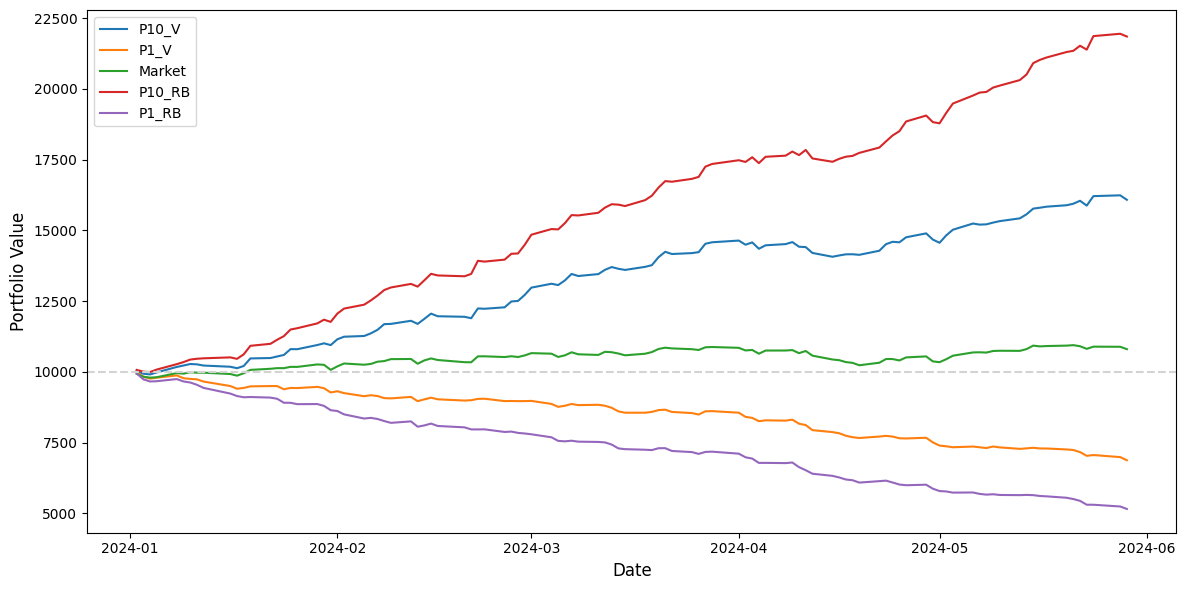

In [220]:
initial_value = 10000

cum_rets_adjusted = (cum_rets + 1) * initial_value

plt.figure(figsize=(12, 6))

for col in cum_rets_adjusted.columns:
    plt.plot(cum_rets_adjusted.index.to_timestamp(), cum_rets_adjusted[col], label=col)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value', fontsize=12)
plt.legend()
plt.axhline(y = 10000, color = 'lightgrey', linestyle = '--') 
plt.grid(True)
plt.tight_layout()
plt.grid(visible=False)

# Show the plot
plt.show()